In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras. layers as layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preparación de los datos

In [379]:
support_pd = pd.read_csv('datos/HistoricData.csv')

In [380]:
support_pd.head()

,Case Owner,Case Record Type,Language,Type,Case Reason,Case Number,Case Origin,Priority,Root Cause,Description,...,Subject,Date/Time Opened,Date/Time Closed,Case Date/Time Last Modified,Case Age (days),Time to FR (Minutes),XX Met SLA,Account Name,JIRA Key,JIRA Status
0,Support Operations,Support Operations,English,Issue,Account - General,660762.0,Support Operations Email,P3 - Normal,NaN,"Hello Team,\n\nToday during the TS managers me...",...,Case summary field and last date and time edited,9/22/2021 2:35 AM,NaN,9/23/2021 9:03 AM,71.29,NaN,NO FR TIME,"Brightcove, Inc. - Master",NaN,NaN
1,Francisco Lancaster,NOC Cases,English,Issue,NaN,662730.0,NOC,P3 - Normal,NaN,This case has been created to coordinate with ...,...,Live Event Coverage for Metropolitan Opera Ass...,10/6/2021 10:31 AM,NaN,10/11/2021 1:15 AM,56.96,NaN,NO FR TIME,"Metropolitan Opera Association, Inc.",NaN,NaN
2,Support Operations,Support Operations,English,Issue,Account - General,665565.0,Support Operations Email,P3 - Normal,NaN,"Hi there,\n\nI'm creating this case to track d...",...,Click tools potential bug,10/28/2021 12:00 PM,NaN,11/8/2021 8:32 AM,34.90,NaN,NO FR TIME,"Brightcove, Inc. - Master",NaN,NaN
3,Paulo Padilla,Case Escalations,English,Issue,Account - General,666505.0,Escalation,P3 - Normal,NaN,"Hi Abraham,\n\nBI have reached out to me regar...",...,Boehringer Ingelheim cases,11/5/2021 9:26 AM,NaN,11/12/2021 4:49 PM,26.96,58.95,ERROR,DNV GL AS,NaN,NaN
4,Dmitry Belakhov,NaN,NaN,Issue,Account - General,362539.0,Automatic Process,P3 - Normal,NaN,Brightcove systems test (ignore this case),...,Brightcove systems test (ignore this case),2/29/2016 9:11 AM,NaN,4/23/2018 4:50 PM,2102.97,NaN,NO FR TIME,NaN,NaN,NaN


In [381]:
support_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448368 entries, 0 to 448367
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Case Owner                    448368 non-null  object 
 1   Case Record Type              209778 non-null  object 
 2   Language                      320622 non-null  object 
 3   Type                          448265 non-null  object 
 4   Case Reason                   385199 non-null  object 
 5   Case Number                   448363 non-null  float64
 6   Case Origin                   447792 non-null  object 
 7   Priority                      344858 non-null  object 
 8   Root Cause                    398272 non-null  object 
 9   Description                   447922 non-null  object 
 10  Product                       417523 non-null  object 
 11  BC Case Reason                433758 non-null  object 
 12  Case Sub Reason               436887 non-nul

In [382]:
support_pd.shape

(448368, 26)

In [383]:
# Removemos las columnas que no se requieren. ('Case Owner', 'Case Number', 'Case Origin', 'Priority', 'Root Cause', 'Case Triage Tier', 'Time in Hours', 'Status', 'Date/Time Opened', 'Date/Time Closed', 'Case Date/Time Last Modified', 'Case Age (days)', 'Time to FR (Minutes)', 'XX Met SLA', 'Account Name', 'JIRA Key', 'JIRA Status')
model_pd = support_pd.drop(['Case Owner', 'Case Number', 'Case Origin', 'Priority', 'Root Cause', 'Case Triage Tier', 'Time in Hours', 'Status', 'Date/Time Opened', 'Date/Time Closed', 'Case Date/Time Last Modified', 'Case Age (days)', 'Time to FR (Minutes)', 'XX Met SLA', 'Account Name', 'JIRA Key', 'JIRA Status'], axis=1)
model_pd.head()

,Case Record Type,Language,Type,Case Reason,Description,Product,BC Case Reason,Case Sub Reason,Subject
0,Support Operations,English,Issue,Account - General,"Hello Team,\n\nToday during the TS managers me...",Video Cloud,NaN,NaN,Case summary field and last date and time edited
1,NOC Cases,English,Issue,NaN,This case has been created to coordinate with ...,Video Cloud,Live Event Coverage,NaN,Live Event Coverage for Metropolitan Opera Ass...
2,Support Operations,English,Issue,Account - General,"Hi there,\n\nI'm creating this case to track d...",Video Cloud,Support Operations,NaN,Click tools potential bug
3,Case Escalations,English,Issue,Account - General,"Hi Abraham,\n\nBI have reached out to me regar...",Video Cloud,NaN,NaN,Boehringer Ingelheim cases
4,NaN,NaN,Issue,Account - General,Brightcove systems test (ignore this case),Video Cloud,NaN,NaN,Brightcove systems test (ignore this case)


In [384]:
model_pd.isna().sum()

Case Record Type    238590
Language            127746
Type                   103
Case Reason          63169
Description            446
Product              30845
BC Case Reason       14610
Case Sub Reason      11481
Subject                 48
dtype: int64

In [385]:
model_pd.isnull().sum()

Case Record Type    238590
Language            127746
Type                   103
Case Reason          63169
Description            446
Product              30845
BC Case Reason       14610
Case Sub Reason      11481
Subject                 48
dtype: int64

In [386]:
model_pd = model_pd.dropna()

In [387]:
model_pd.isnull().sum()

Case Record Type    0
Language            0
Type                0
Case Reason         0
Description         0
Product             0
BC Case Reason      0
Case Sub Reason     0
Subject             0
dtype: int64

In [388]:
model_pd.isna().sum()

Case Record Type    0
Language            0
Type                0
Case Reason         0
Description         0
Product             0
BC Case Reason      0
Case Sub Reason     0
Subject             0
dtype: int64

In [389]:
model_pd.dropna(inplace=True)

In [390]:
model_pd.head()

,Case Record Type,Language,Type,Case Reason,Description,Product,BC Case Reason,Case Sub Reason,Subject
7,CS Documentation,English,Issue,Account - General,CS DOC SKY UK,Video Cloud,CS - Documentation (CS site/ Localization),Create New,CS DOC SKY UK
18,CS Documentation,English,Issue,Account - General,CS Doc Analytics overview training sessions,Video Cloud,CS - Documentation (CS site/ Localization),Create New,CS doc - Analytics training
26,CS Documentation,English,Issue,Account - General,I will do a FEED to chat with product about th...,Video Cloud,CS - Documentation (CS site/ Localization),Create New,Product to clarify the process for zero rating
27,CS Documentation,English,Issue,Account - General,DWS Gatekeeper Support Handoff,Video Cloud,CS - Documentation (CS site/ Localization),Create New,DWS Gatekeeper Support Handoff
28,CS Documentation,Spanish,Issue,Account - General,Timetracker,Partner,CS - Documentation (CS site/ Localization),Create New,Videos for task based cases


In [391]:
model_pd.shape

(196417, 9)

In [392]:
model_pd['Case Record Type'].value_counts()

Customer Support Cases    194216
CS Documentation            1615
Support Operations           585
Case Escalations               1
Name: Case Record Type, dtype: int64

In [393]:
model_pd['Language'].value_counts()

English     177068
Japanese     16924
Korean        2122
Spanish        221
French          63
Italian         10
en               4
German           4
Catalan          1
Name: Language, dtype: int64

In [394]:
model_pd = model_pd[model_pd['Language'] == 'English']

In [395]:
model_pd['Language'].value_counts()

English    177068
Name: Language, dtype: int64

In [396]:
model_pd['Case Record Type'].value_counts()

Customer Support Cases    174869
CS Documentation            1613
Support Operations           585
Case Escalations               1
Name: Case Record Type, dtype: int64

In [397]:
model_pd = model_pd[model_pd['Case Record Type'] == 'Customer Support Cases']

In [398]:
model_pd['Case Record Type'].value_counts()

Customer Support Cases    174869
Name: Case Record Type, dtype: int64

In [399]:
model_pd.head()

,Case Record Type,Language,Type,Case Reason,Description,Product,BC Case Reason,Case Sub Reason,Subject
88,Customer Support Cases,English,Issue,Account - General,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,Other,TapGo new sachet pricing
90,Customer Support Cases,English,Issue,Account - General,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,Plugins - Other,NYPost - Google AMP Analytics for playlists
91,Customer Support Cases,English,Issue,Account - General,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,Plugins - Brightcove,AirPlay pausing from the iOS lock screen
94,Customer Support Cases,English,Issue,Account - General,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Other,Additional Google PlayStore configuration needed
96,Customer Support Cases,English,Issue,Account - General,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Other,Request for BC-JIRA ticket - SG Tourism Board


In [400]:
model_pd['Type'].value_counts()

Issue               174853
Feedback                 9
Network EOL              2
Inquiry                  2
Systems Issue            1
Internal Request         1
Other                    1
Name: Type, dtype: int64

In [401]:
model_pd = model_pd[model_pd['Type'] == 'Issue']

In [402]:
model_pd['Type'].value_counts()

Issue    174853
Name: Type, dtype: int64

In [403]:
model_pd['Case Reason'].value_counts()

Account - General        174835
Abuse                        16
Technical - Uploading         1
Beta - Publishpod             1
Name: Case Reason, dtype: int64

In [404]:
model_pd = model_pd[model_pd['Case Reason'] == 'Account - General']

In [405]:
model_pd['Case Reason'].value_counts()

Account - General    174835
Name: Case Reason, dtype: int64

In [406]:
model_pd = model_pd.drop('Case Sub Reason', axis=1)

In [407]:
model_pd.head()

,Case Record Type,Language,Type,Case Reason,Description,Product,BC Case Reason,Subject
88,Customer Support Cases,English,Issue,Account - General,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,TapGo new sachet pricing
90,Customer Support Cases,English,Issue,Account - General,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,NYPost - Google AMP Analytics for playlists
91,Customer Support Cases,English,Issue,Account - General,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,AirPlay pausing from the iOS lock screen
94,Customer Support Cases,English,Issue,Account - General,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Additional Google PlayStore configuration needed
96,Customer Support Cases,English,Issue,Account - General,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Request for BC-JIRA ticket - SG Tourism Board


In [408]:
model_pd = model_pd.drop('Language', axis=1)
model_pd.head()

,Case Record Type,Type,Case Reason,Description,Product,BC Case Reason,Subject
88,Customer Support Cases,Issue,Account - General,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,TapGo new sachet pricing
90,Customer Support Cases,Issue,Account - General,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,NYPost - Google AMP Analytics for playlists
91,Customer Support Cases,Issue,Account - General,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,AirPlay pausing from the iOS lock screen
94,Customer Support Cases,Issue,Account - General,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Additional Google PlayStore configuration needed
96,Customer Support Cases,Issue,Account - General,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Request for BC-JIRA ticket - SG Tourism Board


In [409]:
model_pd = model_pd.drop('Case Record Type', axis=1)
model_pd.head()

,Type,Case Reason,Description,Product,BC Case Reason,Subject
88,Issue,Account - General,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,TapGo new sachet pricing
90,Issue,Account - General,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,NYPost - Google AMP Analytics for playlists
91,Issue,Account - General,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,AirPlay pausing from the iOS lock screen
94,Issue,Account - General,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Additional Google PlayStore configuration needed
96,Issue,Account - General,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Request for BC-JIRA ticket - SG Tourism Board


In [410]:
model_pd = model_pd.drop('Type', axis=1)
model_pd.head()

,Case Reason,Description,Product,BC Case Reason,Subject
88,Account - General,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,TapGo new sachet pricing
90,Account - General,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,NYPost - Google AMP Analytics for playlists
91,Account - General,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,AirPlay pausing from the iOS lock screen
94,Account - General,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Additional Google PlayStore configuration needed
96,Account - General,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Request for BC-JIRA ticket - SG Tourism Board


In [411]:
model_pd = model_pd.drop('Case Reason', axis=1)
model_pd.head()

,Description,Product,BC Case Reason,Subject
88,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,TapGo new sachet pricing
90,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,NYPost - Google AMP Analytics for playlists
91,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,AirPlay pausing from the iOS lock screen
94,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Additional Google PlayStore configuration needed
96,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Request for BC-JIRA ticket - SG Tourism Board


In [412]:
model_pd['Text'] = model_pd['Subject'] + " " + model_pd['Description']

In [413]:
model_pd.head()

,Description,Product,BC Case Reason,Subject,Text
88,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,TapGo new sachet pricing,TapGo new sachet pricing Hi Support\n\nI'm not...
90,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,NYPost - Google AMP Analytics for playlists,NYPost - Google AMP Analytics for playlists He...
91,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,AirPlay pausing from the iOS lock screen,AirPlay pausing from the iOS lock screen Hello...
94,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Additional Google PlayStore configuration needed,Additional Google PlayStore configuration need...
96,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Request for BC-JIRA ticket - SG Tourism Board,Request for BC-JIRA ticket - SG Tourism Board ...


In [414]:
model_pd['Text'][88]

'TapGo new sachet pricing Hi Support\n\nI\'m not entirely sure this is the right process but it seems the most\nlogical.\nTapGo is a Beacon customer, and they want to define new sachet pricing as\nfollows:\n\n[image: image.png]\n\nThis is also tracked in the sheet TapGo Stores Submission 3Q 2021 tab:\n\nhttps://docs.google.com/spreadsheets/d/1YuG_DRUHoeVJFzHdsG4k_nmwbubWa5ylr3gc2JarDJc/edit#gid=1934417063\n\n"Subscriptions", rows 57 - 74).\n\nEvergent has already defined the sachets in their sandbox environment.\nTo check if the flows are working fine in sandbox with these new passes /\nsachets, Beacon team should also define them.\n\nCan you please help liaising with the Beacon team on this?\n\nThanks\nCatherine'

In [415]:
model_pd['Text'] =   model_pd['Text'].map(lambda x:re.sub('[^a-zA-Z0-9." \n\.]', '', x))

In [416]:
model_pd['Text'] =   model_pd['Text'].map(lambda x:"".join(x))

In [417]:
model_pd['Text'].head()

88    TapGo new sachet pricing Hi Support\n\nIm not ...
90    NYPost  Google AMP Analytics for playlists Hel...
91    AirPlay pausing from the iOS lock screen Hello...
94    Additional Google PlayStore configuration need...
96    Request for BCJIRA ticket  SG Tourism Board Cu...
Name: Text, dtype: object

In [418]:
model_pd['Text'] = model_pd['Text'].replace(r'\n', ' ', regex=True)

In [419]:
model_pd['Text'][88]

'TapGo new sachet pricing Hi Support  Im not entirely sure this is the right process but it seems the most logical. TapGo is a Beacon customer and they want to define new sachet pricing as follows  image image.png  This is also tracked in the sheet TapGo Stores Submission 3Q 2021 tab  httpsdocs.google.comspreadsheetsd1YuGDRUHoeVJFzHdsG4knmwbubWa5ylr3gc2JarDJceditgid1934417063  "Subscriptions" rows 57  74.  Evergent has already defined the sachets in their sandbox environment. To check if the flows are working fine in sandbox with these new passes  sachets Beacon team should also define them.  Can you please help liaising with the Beacon team on this  Thanks Catherine'

In [420]:
model_pd['Text'] = model_pd['Text'].str.replace("  ", " ")

In [421]:
model_pd['Text'][88]

'TapGo new sachet pricing Hi Support Im not entirely sure this is the right process but it seems the most logical. TapGo is a Beacon customer and they want to define new sachet pricing as follows image image.png This is also tracked in the sheet TapGo Stores Submission 3Q 2021 tab httpsdocs.google.comspreadsheetsd1YuGDRUHoeVJFzHdsG4knmwbubWa5ylr3gc2JarDJceditgid1934417063 "Subscriptions" rows 57 74. Evergent has already defined the sachets in their sandbox environment. To check if the flows are working fine in sandbox with these new passes sachets Beacon team should also define them. Can you please help liaising with the Beacon team on this Thanks Catherine'

In [422]:
model_pd['Text'] = model_pd['Text'].str.replace('"', "")

In [423]:
model_pd['Text'][88]

'TapGo new sachet pricing Hi Support Im not entirely sure this is the right process but it seems the most logical. TapGo is a Beacon customer and they want to define new sachet pricing as follows image image.png This is also tracked in the sheet TapGo Stores Submission 3Q 2021 tab httpsdocs.google.comspreadsheetsd1YuGDRUHoeVJFzHdsG4knmwbubWa5ylr3gc2JarDJceditgid1934417063 Subscriptions rows 57 74. Evergent has already defined the sachets in their sandbox environment. To check if the flows are working fine in sandbox with these new passes sachets Beacon team should also define them. Can you please help liaising with the Beacon team on this Thanks Catherine'

In [424]:
model_pd.head()

,Description,Product,BC Case Reason,Subject,Text
88,Hi Support\n\nI'm not entirely sure this is th...,OTT,Beacon,TapGo new sachet pricing,TapGo new sachet pricing Hi Support Im not ent...
90,"Hello,\n\nWe've added the Brightcove AMP plugi...",Video Cloud,Web Player,NYPost - Google AMP Analytics for playlists,NYPost Google AMP Analytics for playlists Hell...
91,"Hello,\n\nWe have noticed an odd issue when ca...",Video Cloud,Web Player,AirPlay pausing from the iOS lock screen,AirPlay pausing from the iOS lock screen Hello...
94,Additional Google PlayStore configuration needed,Video Cloud,Beacon,Additional Google PlayStore configuration needed,Additional Google PlayStore configuration need...
96,Customer: Singapore Tourism Board\nAccount ID:...,Video Cloud,Playback,Request for BC-JIRA ticket - SG Tourism Board,Request for BCJIRA ticket SG Tourism Board Cus...


# Exploración de los datos

In [425]:
X = model_pd['Text'].to_numpy()

In [426]:
X.shape

(174835,)

In [427]:
# Longitud mínima, máxima y promedio
mx = 0
mn = 100000
sm = 0
serie = np.zeros((30960))
print(serie.shape)
for i in range(X.shape[0]):
  l = len(X[i])
  serie[l]=serie[l]+1
  if l>mx:
    mx=l
  if l<mn:
    mn=l
  sm = sm + l
print("Promedio: ", sm/X.shape[0])
print("Min: ", mn)
print("Max: ", mx)

(30960,)
Promedio:  709.5790202190636
Min:  1
Max:  30959


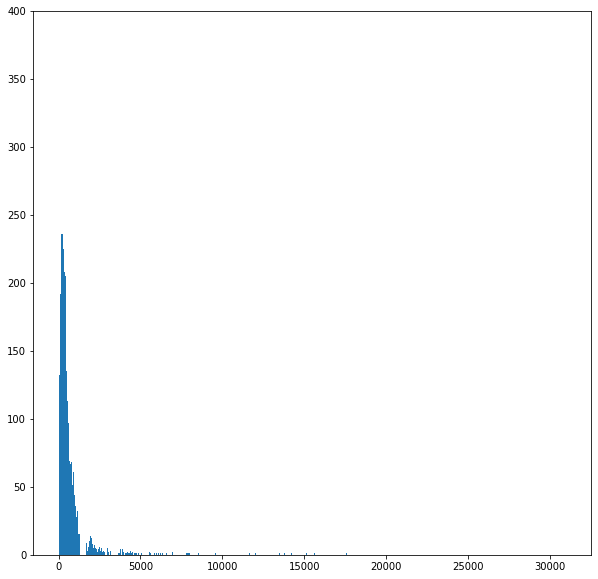

In [428]:
# Grafiquemos el histograma de longitudes de secuencias de texto
import matplotlib.pyplot as plt
import pylab
plt.bar(np.arange(serie.shape[0]),serie)
plt.ylim([0,400])
plt.show()

In [429]:
model_pd['Product'].value_counts()

Video Cloud            154668
Ooyala                   5655
Gallery                  4656
Zencoder                 4225
Once                     3880
OTT                      1364
Perform                   217
Partner                    69
PlayTV                     41
Brightcove Campaign        35
Brightcove Engage          21
App Cloud                   4
Name: Product, dtype: int64

<AxesSubplot:>

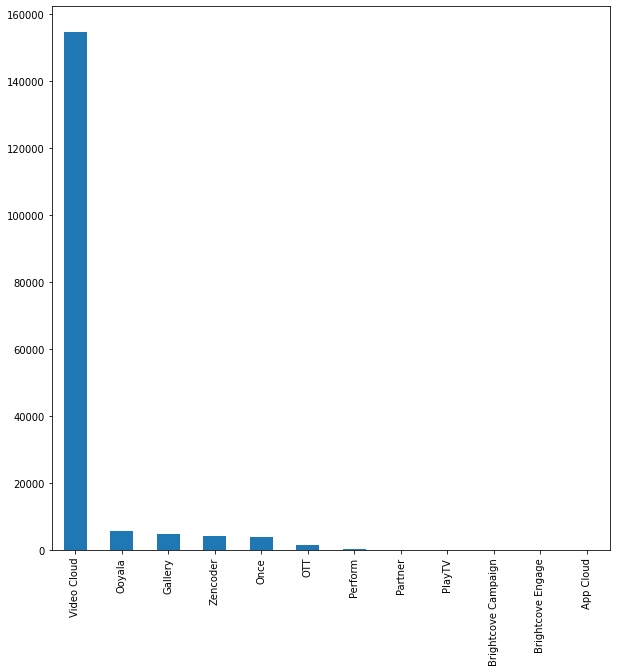

In [430]:
model_pd['Product'].value_counts().plot(kind="bar")

In [431]:
model_pd['BC Case Reason'].value_counts()

Account Settings            46038
Web Player                  15408
API and Custom Dev          12692
Studio                       9559
Playback                     8081
                            ...  
Encoding                        1
Analytics                       1
Premium Advertising             1
Administration - Perform        1
App Playback                    1
Name: BC Case Reason, Length: 94, dtype: int64

<AxesSubplot:>

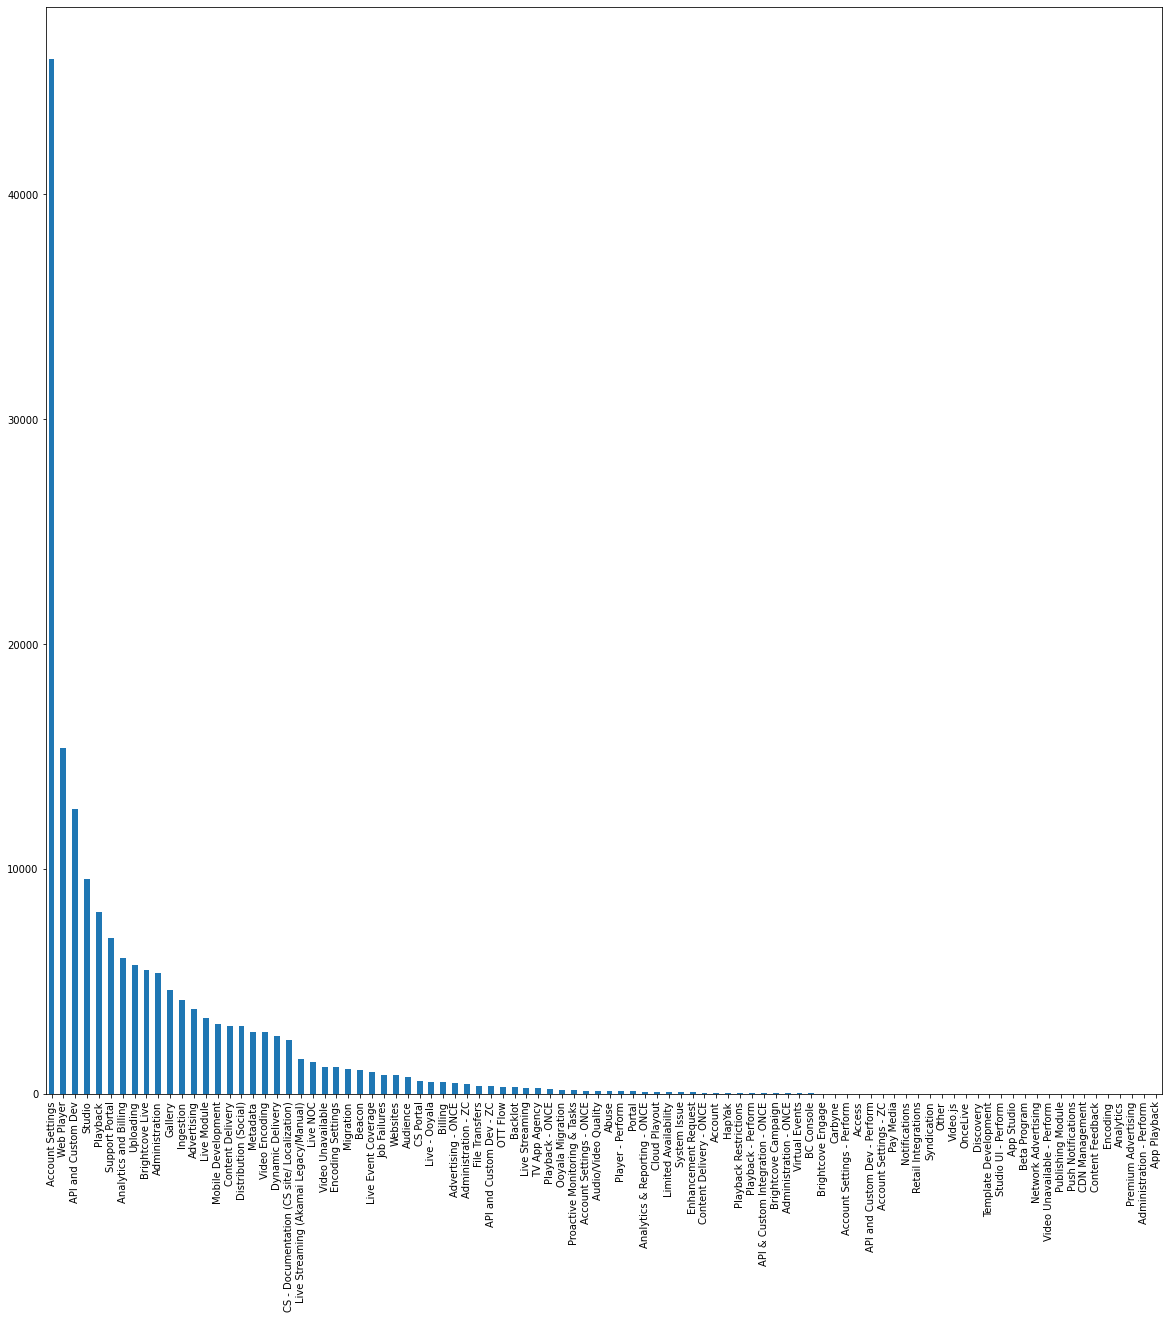

In [508]:
model_pd['BC Case Reason'].value_counts().plot(kind="bar", figsize=(20,20))

# Construcción del modelo

In [440]:
label_encoder = LabelBinarizer()
Y1 = label_encoder.fit_transform(model_pd['Product'])

In [437]:
label_encoder2 = LabelBinarizer()
Y2 = label_encoder2.fit_transform(model_pd['BC Case Reason'])

In [441]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y1, test_size=0.2, random_state=24, shuffle=True)
X2_train, X2_val, Y2_train, Y2_val = train_test_split(X, Y2, test_size=0.2, random_state=24, shuffle=True)

In [444]:
maxlen = 2000

tokenizer = Tokenizer(num_words=6000, oov_token="<OOV>", lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)

X_train_padded = pad_sequences(sequences, maxlen, padding='post', truncating='post')

sequences = tokenizer.texts_to_sequences(X_val)

X_val_padded = pad_sequences(sequences, maxlen, padding='post', truncating='post')

In [463]:
maxlen = 2000

tokenizer = Tokenizer(num_words=6000, oov_token="<OOV>", lower=True)
tokenizer.fit_on_texts(X2_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X2_train)

X2_train_padded = pad_sequences(sequences, maxlen, padding='post', truncating='post')

sequences = tokenizer.texts_to_sequences(X2_val)

X2_val_padded = pad_sequences(sequences, maxlen, padding='post', truncating='post')

In [445]:
print(X_train_padded[0])

[630  22   1 ...   0   0   0]


In [446]:
X_train_padded.shape

(139868, 2000)

In [449]:
Y1.shape[1]

12

## Product model

In [450]:
vocab_size = 6000
embedding_dim = 16 #dimensión de los vectores densos (word embeddings)

model = keras.Sequential([
                          layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
                          layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
                          layers.Bidirectional(layers.LSTM(64)),
                          layers.Dense(12, activation="sigmoid")
])

model.summary()

2021-12-02 13:46:57.985326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:46:58.007775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:46:58.007957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:46:58.009019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 16)          96000     
                                                                 
 bidirectional (Bidirectiona  (None, 2000, 128)        41472     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 12)                1548      
                                                                 
Total params: 237,836
Trainable params: 237,836
Non-trainable params: 0
_________________________________________________________________


In [451]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [452]:
h = model.fit(X_train_padded, Y_train, epochs=2, validation_data=(X_val_padded, Y_val))

Epoch 1/2


2021-12-02 13:47:48.724395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2021-12-02 13:47:48.940105: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4371/4371 [==============================] - 871s 199ms/step - loss: 0.2901 - accuracy: 0.9249 - val_loss: 0.2165 - val_accuracy: 0.9405
Epoch 2/2
4371/4371 [==============================] - 870s 199ms/step - loss: 0.1992 - accuracy: 0.9437 - val_loss: 0.1879 - val_accuracy: 0.9437


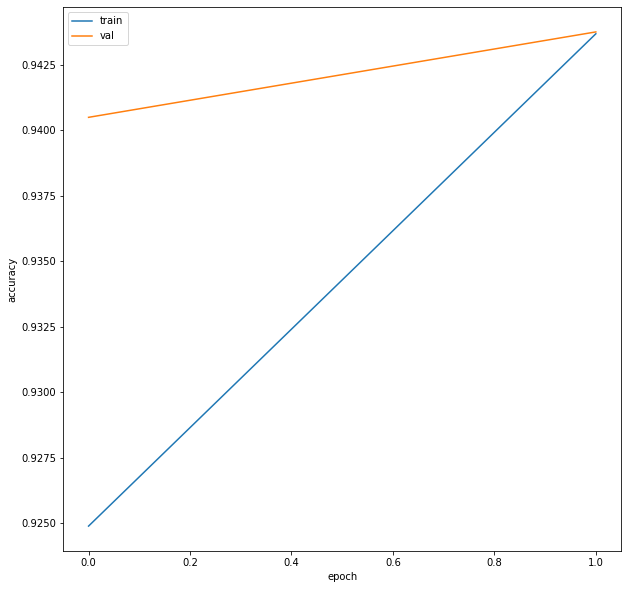

In [453]:
from matplotlib import pyplot as plt
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [458]:
product = model.evaluate(X_val_padded, Y_val, verbose=1)

1093/1093 [==============================] - 84s 77ms/step - loss: 0.1879 - accuracy: 0.9437


In [456]:
test = np.amax(product)

array([[0.00316848, 0.0742064 , 0.02548435, ..., 0.04758876, 0.99358624,
        0.35268545],
       [0.00523924, 0.04515272, 0.06434163, ..., 0.06860866, 0.97555155,
        0.87473315],
       [0.00377227, 0.04726546, 0.0106228 , ..., 0.03330581, 0.99654824,
        0.4333279 ],
       ...,
       [0.00177681, 0.05132183, 0.00566   , ..., 0.01950614, 0.9985525 ,
        0.31954512],
       [0.0024245 , 0.0544186 , 0.00773553, ..., 0.02167354, 0.9983992 ,
        0.40721366],
       [0.00210065, 0.05114279, 0.00694792, ..., 0.0189482 , 0.99852175,
        0.37352073]], dtype=float32)

## Sub-product model

In [459]:
Y2_train.shape

(139868, 94)

In [460]:
vocab_size = 6000
embedding_dim = 16 #dimensión de los vectores densos (word embeddings)

model2 = keras.Sequential([
                          layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
                          layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
                          layers.Bidirectional(layers.LSTM(64)),
                          layers.Dense(94, activation="sigmoid")
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2000, 16)          96000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 2000, 128)        41472     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 94)                12126     
                                                                 
Total params: 248,414
Trainable params: 248,414
Non-trainable params: 0
_________________________________________________________________


In [461]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [464]:
h2 = model2.fit(X2_train_padded, Y2_train, epochs=2, validation_data=(X2_val_padded, Y2_val))

Epoch 1/2
4371/4371 [==============================] - 874s 200ms/step - loss: 1.7072 - accuracy: 0.5322 - val_loss: 1.4313 - val_accuracy: 0.5987
Epoch 2/2
4371/4371 [==============================] - 864s 198ms/step - loss: 1.3205 - accuracy: 0.6247 - val_loss: 1.2823 - val_accuracy: 0.6307


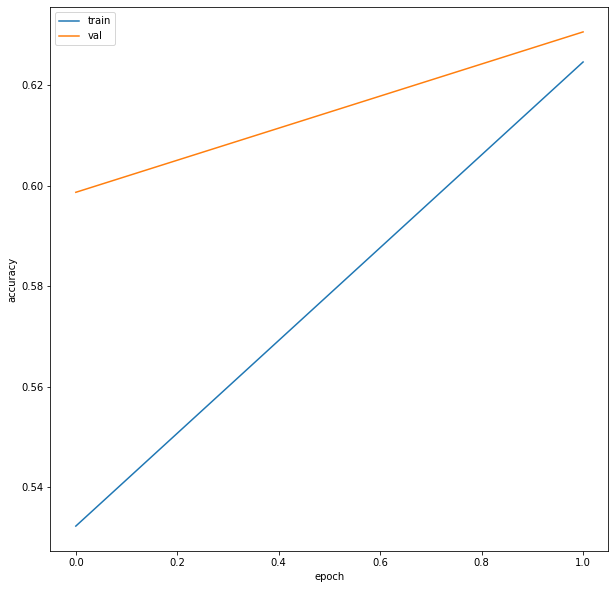

In [465]:
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [466]:
product = model2.evaluate(X2_val_padded, Y2_val, verbose=1)

1093/1093 [==============================] - 87s 79ms/step - loss: 1.2823 - accuracy: 0.6307


In [499]:
vocab_size = 6000
embedding_dim = 16 #dimensión de los vectores densos (word embeddings)

#input_layer = keras.Sequential()
input_layer= layers.Input(maxlen)

prod_layer = layers.Embedding(vocab_size, embedding_dim)(input_layer)
subprod_layer = layers.Embedding(vocab_size, embedding_dim)(input_layer)

prod_layer = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(prod_layer)
prod_layer = layers.Bidirectional(layers.LSTM(64))(prod_layer)
prod_layer = layers.Dense(12, activation="sigmoid", name="prod")(prod_layer)

subprod_layer = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(subprod_layer)
subprod_layer = layers.Bidirectional(layers.LSTM(64))(subprod_layer)
subprod_layer = layers.Dense(94, activation="sigmoid", name="subprod")(subprod_layer)

model3 = keras.Model(inputs=input_layer, outputs=[prod_layer,subprod_layer], name="SupportModel")
model3.summary()

Model: "SupportModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 2000)]       0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 2000, 16)     96000       ['input_14[0][0]']               
                                                                                                  
 embedding_12 (Embedding)       (None, 2000, 16)     96000       ['input_14[0][0]']               
                                                                                                  
 bidirectional_27 (Bidirectiona  (None, 2000, 128)   41472       ['embedding_11[0][0]']           
 l)                                                                                    

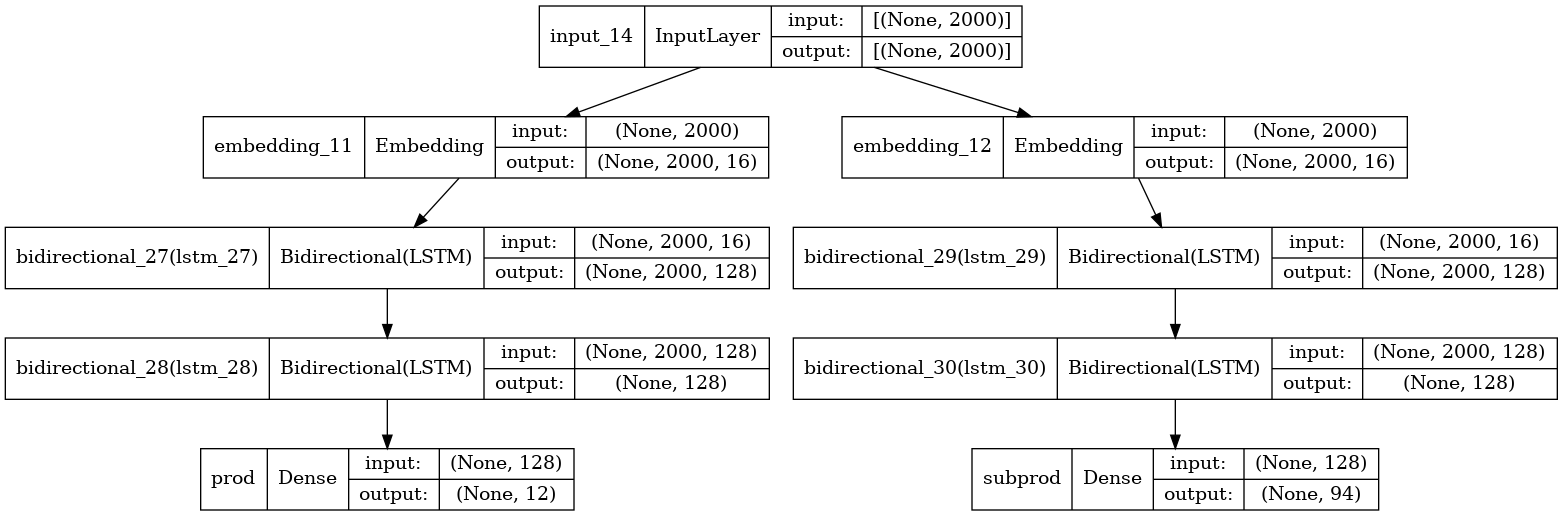

In [500]:
tf.keras.utils.plot_model(model3, show_shapes=True)

In [503]:
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [504]:
metrics = {
	"box": ['accuracy'],
	"class": ['accuracy']
}

In [505]:
h3 = model3.fit(
    x = X2_train_padded, 
    y= {
        "prod": Y_train,
        "subprod": Y2_train
    }, 
    epochs=5, 
    validation_data=(
        X2_val_padded, 
        {"prod": Y_val,
        "subprod": Y2_val
    }),
    verbose=1
    )

Epoch 1/5
4371/4371 [==============================] - 1741s 397ms/step - loss: 2.3162 - prod_loss: 0.3205 - subprod_loss: 1.9957 - prod_accuracy: 0.9136 - subprod_accuracy: 0.4600 - val_loss: 1.7438 - val_prod_loss: 0.2130 - val_subprod_loss: 1.5308 - val_prod_accuracy: 0.9420 - val_subprod_accuracy: 0.5778
Epoch 2/5
4371/4371 [==============================] - 1734s 397ms/step - loss: 1.5756 - prod_loss: 0.1962 - subprod_loss: 1.3794 - prod_accuracy: 0.9434 - subprod_accuracy: 0.6110 - val_loss: 1.4794 - val_prod_loss: 0.1895 - val_subprod_loss: 1.2899 - val_prod_accuracy: 0.9454 - val_subprod_accuracy: 0.6292
Epoch 3/5
4371/4371 [==============================] - 1707s 391ms/step - loss: 1.3954 - prod_loss: 0.1700 - subprod_loss: 1.2254 - prod_accuracy: 0.9490 - subprod_accuracy: 0.6449 - val_loss: 1.3879 - val_prod_loss: 0.1705 - val_subprod_loss: 1.2173 - val_prod_accuracy: 0.9491 - val_subprod_accuracy: 0.6439
Epoch 4/5
4371/4371 [==============================] - 1665s 381ms/ste

In [506]:
product3 = model3.evaluate(x= X_val_padded, y={"prod": Y_val, "subprod":Y2_val}, verbose=1)

1093/1093 [==============================] - 174s 159ms/step - loss: 1.3513 - prod_loss: 0.1621 - subprod_loss: 1.1892 - prod_accuracy: 0.9505 - subprod_accuracy: 0.6514


In [547]:
X_val_padded[0].shape

(2000,)

In [562]:
tokenizer.sequences_to_texts([X_val_padded[2000]])

['sharing error between <OOV> and <OOV> accounts getting an error custom field conflict when sharing videos with the <OOV> account <OOV> has added the <OOV> <OOV> tags but some of the other custom fields do not match when the <OOV> team tried to add custom fields they received the message there was an error creating the custom field could you please verify what the <OOV> is that we are missing for sharing compatibility between these two accounts thank you <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> 

In [564]:
testing = tf.reshape(X_val_padded[2000], (-1,2000))

In [565]:
producto, subproducto = model3.predict(testing)

In [566]:
print(np.argmax(producto))
print(np.argmax(subproducto))

10
58


In [567]:
label_encoder.inverse_transform(producto)[0]


'Video Cloud'

In [569]:
label_encoder2.inverse_transform(subproducto)[0]

'Metadata'